# Communities over Time

In [1]:
# automatically reload imports before executing any line in case you changed something
%load_ext autoreload
%autoreload 2


In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

In [3]:
#df = pd.read_csv("../data/raw/Postings_01052019_15052019.csv", delimiter=";")
df = utils.read_all_postings()
df_inland = df[df["ArticleChannel"] == "Inland"]
df_inland.head()

df_votes = utils.read_all_votes()

In [4]:
df_inland["ID_Article"].value_counts()[:-50]

2000103364196    12042
2000103990942     5173
2000103773909     4789
2000103772847     4290
2000103578888     3918
                 ...  
2000103481296       27
2000102439421       27
2000103476175       26
2000104041104       25
2000103131990       25
Name: ID_Article, Length: 277, dtype: int64

In [5]:
# "Welcher ""Austausch"" der Bevölkerung in Österreich tatsächlich stattfindet"
#art_selected = df_inland[df_inland["ID_Article"] == 2000102386715]

#smaller article for easier debugging of metrics
article_id = 2000103481296

art_selected = df_inland[df_inland["ID_Article"] == article_id]
p_ids = art_selected["ID_Posting"].unique()

votes_selected = df_votes[df_votes["ID_Posting"].isin(p_ids)]
joined = art_selected.merge(votes_selected, on="ID_Posting", suffixes=("_p", "_v"))
joined.head()

## use method to get all up/down votes of each post
g_pos = read_graph.get_users_voted_other_users(postings=art_selected, votes=votes_selected)
g_neg = read_graph.get_users_voted_other_users(postings=art_selected, votes=votes_selected, positive_vote=False)


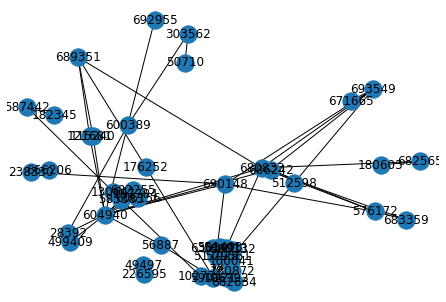

In [6]:
nx.draw(g_pos, with_labels=True, arrows=False)

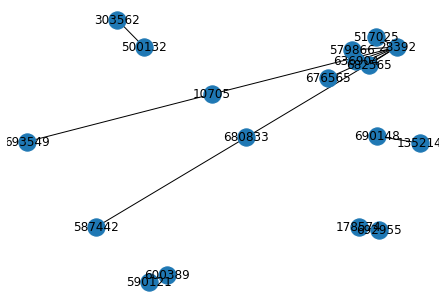

In [7]:
nx.draw(g_neg, with_labels=True, arrows=False)

## Community Metrics

- Nr Communities
- Degree Distribution
- Global Clustering Coefficient
- Average Degree ?
- Weakly/Strongly connected components

- number of interactions/number of users

In [8]:
# this is very slow and weird

from networkx.algorithms import community
communities_generator = community.girvan_newman(g_pos)
top_ = next(communities_generator)
sec_ = next(communities_generator)


In [15]:
Gs = [g_pos, g_neg]

for G in Gs:
    print("---")
    com = list(community.greedy_modularity_communities(nx.Graph(G)))
    print("Number of Communities: ", len(com))
    mod = community.modularity(G, community.greedy_modularity_communities(nx.Graph(G)))
    print("mod: ", mod)
    gcc = nx.average_clustering(G)
    print("GCC: ", gcc)


---
Number of Communities:  6
mod:  0.5500637755102041
GCC:  0.034147334147334146
---
Number of Communities:  7
mod:  0.5917159763313611
GCC:  0.0


In [16]:
Gs = [g_pos, g_neg]

for G in Gs:
    print("---")
    com = utils.get_communities(G, min_size=0)
    print("Number of Communities: ", len(com))
    mod = community.modularity(G, utils.get_communities(G, min_size=0))
    print("mod: ", mod)
    gcc = nx.average_clustering(G)
    print("GCC: ", gcc)
    

---
Number of Communities:  6
mod:  0.5487882653061225
GCC:  0.034147334147334146
---
Number of Communities:  7
mod:  0.5917159763313611
GCC:  0.0


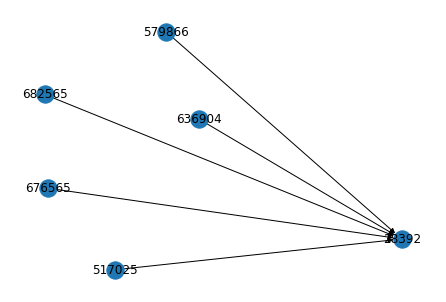

In [17]:
nx.draw(G.subgraph(list(utils.get_communities(G, min_size=0))[0]), with_labels=True, arrows=True)

In [75]:
communities_generator = community.girvan_newman(g_pos)
for i in range(30):
    print(community.modularity(g_pos, next(communities_generator)))

0.387436224489796
0.4540816326530613
0.4719387755102042
0.5360331632653061
0.5334821428571429
0.529655612244898
0.5220025510204082
0.5143494897959184
0.5066964285714286
0.4939413265306123
0.481186224489796
0.467155612244898
0.45663265306122447
0.44387755102040816
0.43112244897959184
0.4164540816326531
0.40369897959183676
0.39094387755102045
0.37531887755102034
0.360969387755102
0.3459821428571428
0.3332270408163265
0.3051658163265306
0.2908163265306122
0.27806122448979587
0.26817602040816324
0.2528698979591837
0.2385204081632653
0.225765306122449
0.19738520408163268


## Reuse code from others

In [40]:
all_votes = utils.read_all_votes()
all_postings = utils.read_all_postings()
postings_inl = all_postings.query("ArticleChannel == 'Inland'")

In [60]:
article_id = 2000103481296

art_selected = postings_inl[postings_inl["ID_Article"] == article_id]

G = read_graph.get_all_users_interactions(art_selected, all_votes, multi_di_graph=True, with_timestamp=True)
G_timerange = nx.get_edge_attributes(G, "created_at").values()
interval = (min(G_timerange), max(G_timerange))

In [61]:
G_red = utils.reduce_multi_graph(G, thresh=0)
communities = utils.get_communities(G_red, min_size=0, sort_by_sum_interactions=True)

Gs = [utils.generate_snapshots_over_time(
    G_video.subgraph(c), minutes=5, max_snapshots=150, interval=interval, include_final=False)
      for c in communities[:3]]

Gs = utils.generate_snapshots_over_time(G, minutes=60, max_snapshots=150, interval=interval, include_final=False)


In [80]:
for thisG in Gs.values():
    print(thisG)
    print("---")
    com = utils.get_communities(thisG, min_size=0)
    print("Number of Communities: ", len(com))
    mod = community.modularity(thisG, utils.get_communities(thisG, min_size=0))
    print("mod: ", mod)
    gcc = nx.average_clustering(thisG)
    print("GCC: ", gcc)


---
Number of Communities:  1
mod:  0.0
GCC:  0.0

---
Number of Communities:  4
mod:  0.5204081632653061
GCC:  0.0

---
Number of Communities:  5
mod:  0.5729166666666666
GCC:  0.0

---
Number of Communities:  5
mod:  0.5280612244897959
GCC:  0.0

---
Number of Communities:  7
mod:  0.6737500000000001
GCC:  0.0

---
Number of Communities:  6
mod:  0.6420118343195268
GCC:  0.0

---
Number of Communities:  6
mod:  0.6183333333333333
GCC:  0.0

---
Number of Communities:  8
mod:  0.6673875432525952
GCC:  0.0

---
Number of Communities:  9
mod:  0.6623931623931624
GCC:  0.0

---
Number of Communities:  9
mod:  0.6623931623931624
GCC:  0.0

---
Number of Communities:  9
mod:  0.6805268595041322
GCC:  0.04595959595959596

---
Number of Communities:  9
mod:  0.6805268595041322
GCC:  0.04595959595959596

---
Number of Communities:  9
mod:  0.6805268595041322
GCC:  0.04595959595959596

---
Number of Communities:  9
mod:  0.6805268595041322
GCC:  0.04595959595959596

---
Number of Communities:

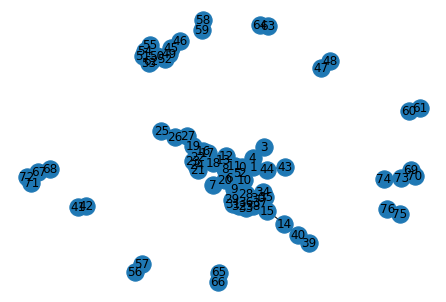

In [42]:
nx.draw(G_red, with_labels=True, arrows=True)

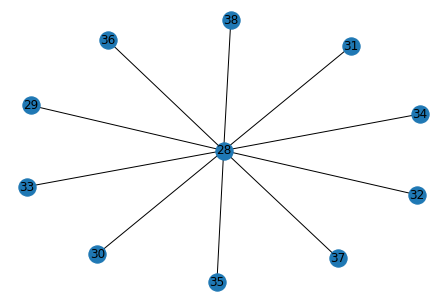

In [43]:
nx.draw(G_red.subgraph(communities[2]), with_labels=True, arrows=True)

In [ ]:
interval = (min(created_ats), max(created_ats))